# RL Assignement NAMOUH

In [4]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\abder\appdata\local\temp\pip-req-build-piza7ad8
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\abder\AppData\Local\Temp\pip-req-build-piza7ad8'


In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import text_flappy_bird_gym

In [8]:
# Initialize the environment
env = gym.make('TextFlappyBird-v0')  # Use 'TextFlappyBird-screen-v0' for the full-screen version

In [9]:
def evaluate_agent(env, agent, num_episodes=100):
    total_rewards = []
    
    for i in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, info = env.step(action)
            if done:
                reward = -1
            total_reward += reward
            state = next_state
            if done:
                break
        total_rewards.append(total_reward)
        env.close()

    average_reward = np.mean(total_rewards)
    print(f"Average Reward: {average_reward}")
    return average_reward, total_rewards

# Different Agents

#### Random Agent

In [11]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def select_action(self, state):
        # Randomly select an action
        return self.action_space.sample()

# Create a RandomAgent instance with the environment's action space
random_agent = RandomAgent(env.action_space)
average_reward, rewards_per_episode = evaluate_agent(env, random_agent, num_episodes=10000)

Average Reward: 9.3722


#### Monte Carlo Agent

In [47]:


class MonteCarloAgent:
    """
    Implements a Monte Carlo strategy for learning optimal policies in game-like environments,
    tailored to the specific requirements of a given scenario.
    """

    def __init__(self, epsilon = 0.1, discount = 0.9):
        self.exploration_rate = epsilon # Probability of exploration
        self.discount_factor = discount  # Discount factor for future reward
        # Q-values for state-action pairs, initialized to zero
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        # History of returns for each state-action pair to calculate averages
        self.returns_sum = defaultdict(list)
        self.state_num = defaultdict(lambda: np.zeros(env.action_space.n))
        self.policy = defaultdict(int)

    def select_action(self, current_state):
        """
        Chooses an action based on an epsilon-greedy strategy.
        """
        if np.random.rand() < self.exploration_rate:
            return env.action_space.sample()  # Exploration: random action
        return np.argmax(self.q_values[current_state])  # Exploitation: best known action

    def update_policy(self, episode):
        G = 0 
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount_factor * G + reward
            if (state, action) not in visited:
                self.state_num[state][action] += 1
                self.q_values[state][action] += (G - self.q_values[state][action]) / self.state_num[state][action]
                visited.add((state,action))

    def train(self, env, episodes_count):
        """
        Executes the training process over a specified number of episodes.
        """
        all_rewards = []
        for _ in tqdm(range(episodes_count)):
            episode = []
            current_state = env.reset()[0]  # Initial state handling
            done = False
            total_reward = 0
            while not done:
                action = self.select_action(current_state)
                next_state, reward, done, _, _ = env.step(action)
                if done:
                    reward = -1  # Terminal state penalty
                total_reward += reward
                episode.append((current_state, action, reward))
                current_state = next_state
            all_rewards.append(total_reward)
            self.update_policy(episode)
            env.close()  

        return all_rewards
        
MC_agent = MonteCarloAgent(epsilon = 0.1, discount = 0.9)
MC_rewards = MC_agent.train(env, 10000)
average_reward, rewards_per_episode = evaluate_agent(env, MC_agent, num_episodes=1000)

100%|██████████| 10000/10000 [00:18<00:00, 553.41it/s]


Average Reward: 125.847


#### Sarsa Agent

In [50]:
class SARSAgent:
    """
    Implements SARSA learning algorithm for reinforcement learning tasks.
    Optimized for clarity and efficient handling of the environment's outputs.
    """

    def __init__(self, epsilon = 0.1, learning_rate = 0.5, discount = 0.9):
        self.exploration_rate = epsilon  # Probability of choosing a random action
        self.learning_rate = learning_rate  # Rate of Q-value updates
        self.discount_factor = discount  # Discount factor for future rewards
        # Q-table for storing the value of state-action pairs, initialized to zero for all actions
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

    def select_action(self, current_state):
        """
        Selects an action using an epsilon-greedy policy.
        """
        if np.random.rand() < self.exploration_rate:
            return env.action_space.sample()  # Exploration: random action
        return np.argmax(self.q_values[current_state])  # Exploitation: action with the highest Q-value

    def update_policy(self, state, action, next_state, next_action, reward):
        """
        Updates Q-values based on the SARSA algorithm.
        """
        prediction = self.q_values[state][action]
        target = reward + self.discount_factor * self.q_values[next_state][next_action]
        self.q_values[state][action] += self.learning_rate * (target - prediction)

    def train(self, env, episodes):
        """
        Trains the agent on the environment for a specified number of episodes.
        """
        all_rewards = []
        for episode in tqdm(range(episodes)):
            current_state = env.reset()[0]  # Assuming the environment returns initial state in a specific format
            done = False
            total_reward = 0
            while not done:
                action = self.select_action(current_state)
                next_state, reward, done, _ = env.step(action)[:4]

                if done:
                    reward = -1  # Penalty for terminal state

                total_reward += reward
                next_action = self.select_action(next_state)
                self.update_policy(current_state, action, next_state, next_action, reward)
                current_state, action = next_state, next_action

            all_rewards.append(total_reward)
            env.close()
        return all_rewards


sarsa_agent = SARSAgent(epsilon = 0.1, learning_rate = 0.5, discount = 0.9)
sarsa_rewards = sarsa_agent.train(env, 10000)
average_reward, rewards_per_episode = evaluate_agent(env, sarsa_agent , num_episodes=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:12<00:00, 779.74it/s]


Average Reward: 55.562


# Agents Comparisons

##

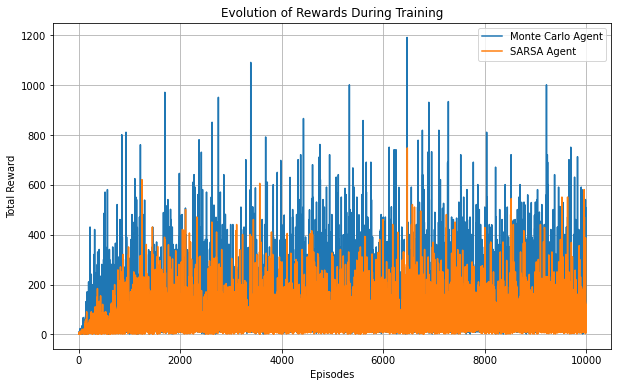

In [52]:
episodes = range(1, len(sarsa_rewards) + 1)

plt.figure(figsize=(10, 6))

plt.plot(episodes, MC_rewards, label='Monte Carlo Agent')
plt.plot(episodes, sarsa_rewards, label='SARSA Agent')

plt.title('Evolution of Rewards During Training')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

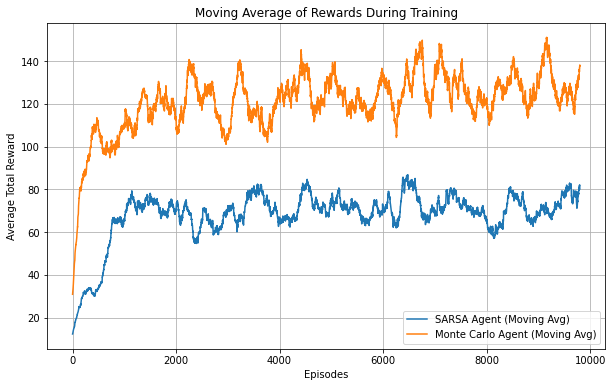

In [55]:
# Function to calculate the moving average of rewards
def moving_average(rewards, window_size=200):
    return np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

# Calculate moving averages
sarsa_ma = moving_average(sarsa_rewards)
monte_carlo_ma = moving_average(MC_rewards)

# Adjusted episodes range for moving average (due to 'valid' mode in convolution)
ma_episodes = range(1, len(sarsa_ma) + 1)

plt.figure(figsize=(10, 6))
plt.plot(ma_episodes, sarsa_ma, label='SARSA Agent (Moving Avg)')
plt.plot(ma_episodes, monte_carlo_ma, label='Monte Carlo Agent (Moving Avg)')
plt.title('Moving Average of Rewards During Training')
plt.xlabel('Episodes')
plt.ylabel('Average Total Reward')
plt.legend()
plt.grid(True)
plt.show()


## State Value Function

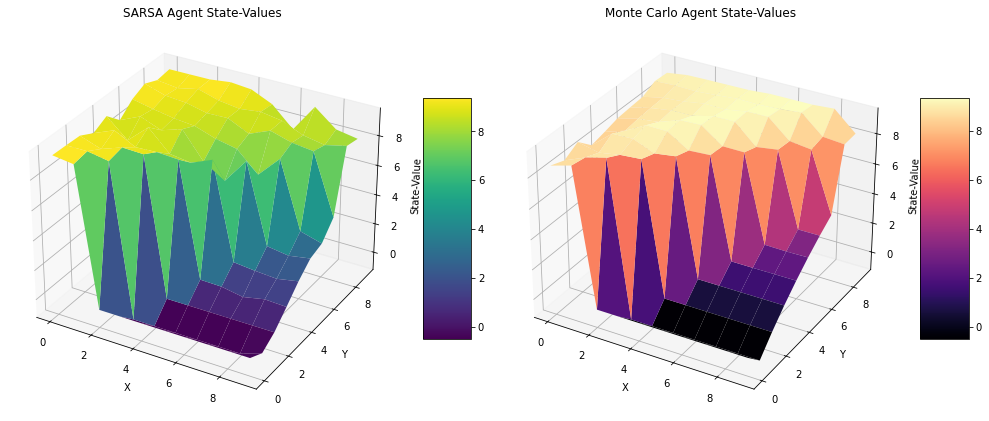

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Function to extract state values from Q-values
def get_state_values(q_values):
    x = np.arange(0, 10)  # Adjust based on your state space
    y = np.arange(0, 10)  # Adjust based on your state space
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X, dtype=float)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j])
            Z[i, j] = np.max(q_values[state]) if state in q_values else 0
    
    return X, Y, Z

# Assuming sarsa_q_values and monte_carlo_q_values are your trained Q-values
X, Y, Z_sarsa = get_state_values(sarsa_agent.q_values)
_, _, Z_monte_carlo = get_state_values(MC_agent.q_values)

# Plotting
fig = plt.figure(figsize=(14, 7))

# SARSA
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface( Y, X, Z_sarsa, cmap='viridis')
ax1.set_title('SARSA Agent State-Values')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('State-Value')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Monte Carlo
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface( Y, X, Z_monte_carlo, cmap='magma')
ax2.set_title('Monte Carlo Agent State-Values')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('State-Value')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


## Parameter Finetuning

#### Epsilon

training with epsilon=0.1


100%|██████████| 10000/10000 [00:19<00:00, 525.11it/s]


training with epsilon=0.2


100%|██████████| 10000/10000 [00:10<00:00, 984.19it/s]


training with epsilon=0.3


100%|██████████| 10000/10000 [00:06<00:00, 1485.98it/s]


training with epsilon=0.4


100%|██████████| 10000/10000 [00:04<00:00, 2019.67it/s]


training with epsilon=0.5


100%|██████████| 10000/10000 [00:03<00:00, 2580.56it/s]


training with epsilon=0.6


100%|██████████| 10000/10000 [00:03<00:00, 2920.72it/s]


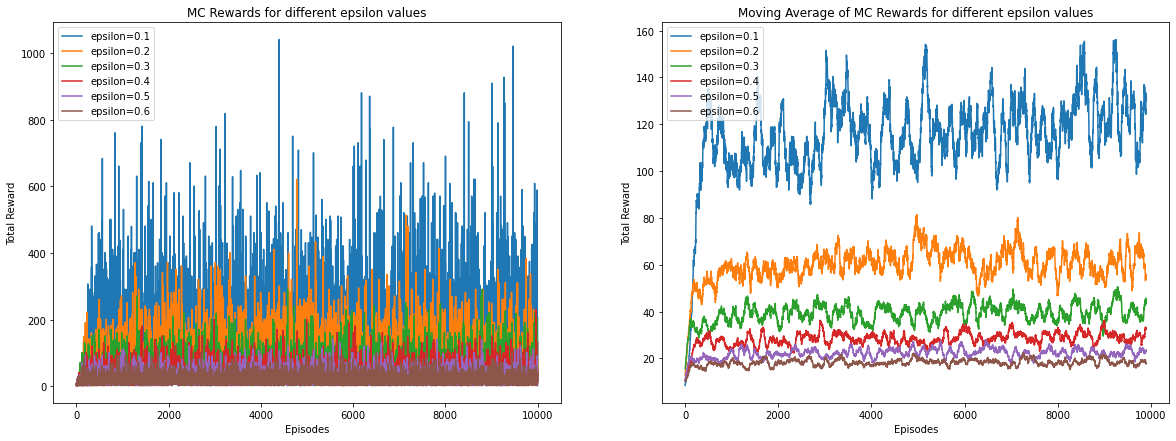

In [65]:
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Dictionary to hold the rewards for each epsilon value
all_rewards = {}

# Loop over epsilon values, train the agent, and collect rewards
for eps in epsilon_values:
    print(f"training with epsilon={eps}")
    agent = MonteCarloAgent(epsilon=eps, discount=0.9)
    all_rewards[eps] = agent.train(env, 10000)

def moving_average(rewards, window_size=100):
    """ Helper function to calculate the moving average of the rewards. """
    cumulative_sum = np.cumsum(np.insert(rewards, 0, 0)) 
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

plt.figure(figsize=(20,7))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
for eps, rewards in all_rewards.items():
    plt.plot(rewards, label=f'epsilon={eps}')
plt.title('MC Rewards for different epsilon values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 2, 2)
for eps, rewards in all_rewards.items():
    plt.plot(moving_average(rewards), label=f'epsilon={eps}')
plt.title('Moving Average of MC Rewards for different epsilon values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

training with epsilon=0.1


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:12<00:00, 792.16it/s]


training with epsilon=0.2


100%|██████████| 10000/10000 [00:07<00:00, 1285.23it/s]


training with epsilon=0.3


100%|██████████| 10000/10000 [00:06<00:00, 1601.97it/s]


training with epsilon=0.4


100%|██████████| 10000/10000 [00:05<00:00, 1928.51it/s]


training with epsilon=0.5


100%|██████████| 10000/10000 [00:04<00:00, 2225.97it/s]


training with epsilon=0.6


100%|██████████| 10000/10000 [00:04<00:00, 2496.43it/s]


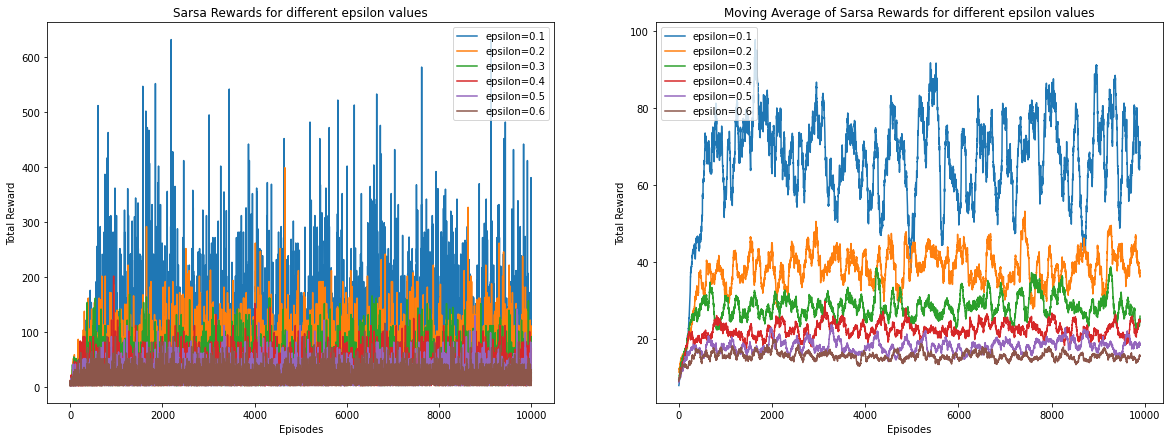

In [66]:
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Dictionary to hold the rewards for each epsilon value
all_rewards = {}

# Loop over epsilon values, train the agent, and collect rewards
for eps in epsilon_values:
    print(f"training with epsilon={eps}")
    agent = SARSAgent(epsilon=eps, learning_rate=0.5, discount=0.9)
    all_rewards[eps] = agent.train(env, 10000)

def moving_average(rewards, window_size=100):
    """ Helper function to calculate the moving average of the rewards. """
    cumulative_sum = np.cumsum(np.insert(rewards, 0, 0)) 
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

plt.figure(figsize=(20,7))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
for eps, rewards in all_rewards.items():
    plt.plot(rewards, label=f'epsilon={eps}')
plt.title('Sarsa Rewards for different epsilon values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 2, 2)
for eps, rewards in all_rewards.items():
    plt.plot(moving_average(rewards), label=f'epsilon={eps}')
plt.title('Moving Average (100) of Sarsa Rewards for different epsilon values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

#### Discount

training with discout=0.1


100%|██████████| 10000/10000 [00:09<00:00, 1033.55it/s]


training with discout=0.3


100%|██████████| 10000/10000 [00:11<00:00, 901.23it/s]


training with discout=0.5


100%|██████████| 10000/10000 [00:12<00:00, 816.30it/s]


training with discout=0.7


100%|██████████| 10000/10000 [00:16<00:00, 617.39it/s]


training with discout=0.9


100%|██████████| 10000/10000 [00:16<00:00, 603.32it/s]


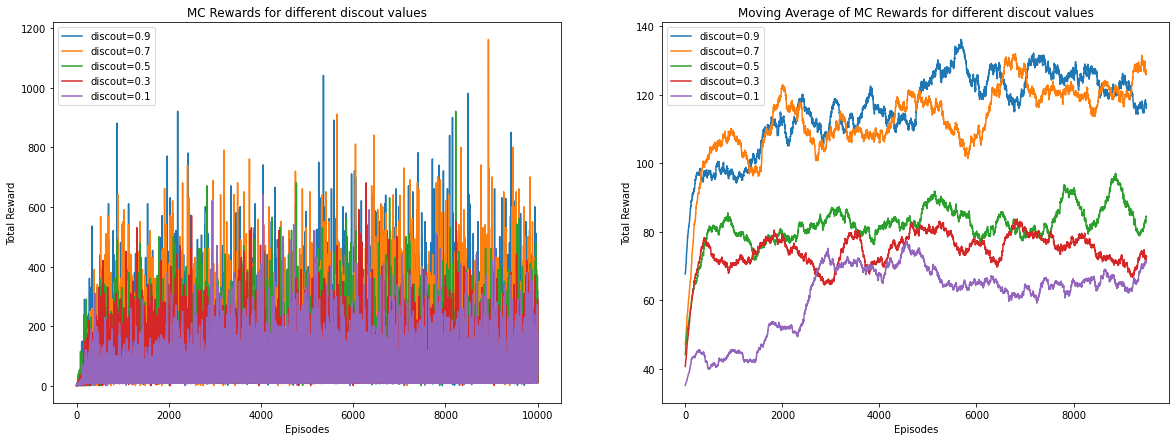

In [69]:
discout_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Dictionary to hold the rewards for each discout value
all_rewards = {}

# Loop over discout values, train the agent, and collect rewards
for disc in discout_values:
    print(f"training with discout={disc}")
    agent = MonteCarloAgent(epsilon=0.1, discount=disc)
    all_rewards[disc] = agent.train(env, 10000)

def moving_average(rewards, window_size=500):
    """ Helper function to calculate the moving average of the rewards. """
    cumulative_sum = np.cumsum(np.insert(rewards, 0, 0)) 
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

plt.figure(figsize=(20,7))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
for disc, rewards in reversed(all_rewards.items()):
    plt.plot(rewards, label=f'discout={disc}')
plt.title('MC Rewards for different discout values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 2, 2)
for disc, rewards in reversed(all_rewards.items()):
    plt.plot(moving_average(rewards), label=f'discout={disc}')
plt.title('Moving Average (500) of MC Rewards for different discout values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

training with discout=0.1


100%|██████████| 10000/10000 [00:09<00:00, 1103.84it/s]


training with discout=0.3


100%|██████████| 10000/10000 [00:10<00:00, 989.63it/s]


training with discout=0.5


100%|██████████| 10000/10000 [00:11<00:00, 859.78it/s]


training with discout=0.7


100%|██████████| 10000/10000 [00:12<00:00, 801.49it/s]


training with discout=0.9


100%|██████████| 10000/10000 [00:12<00:00, 803.01it/s]


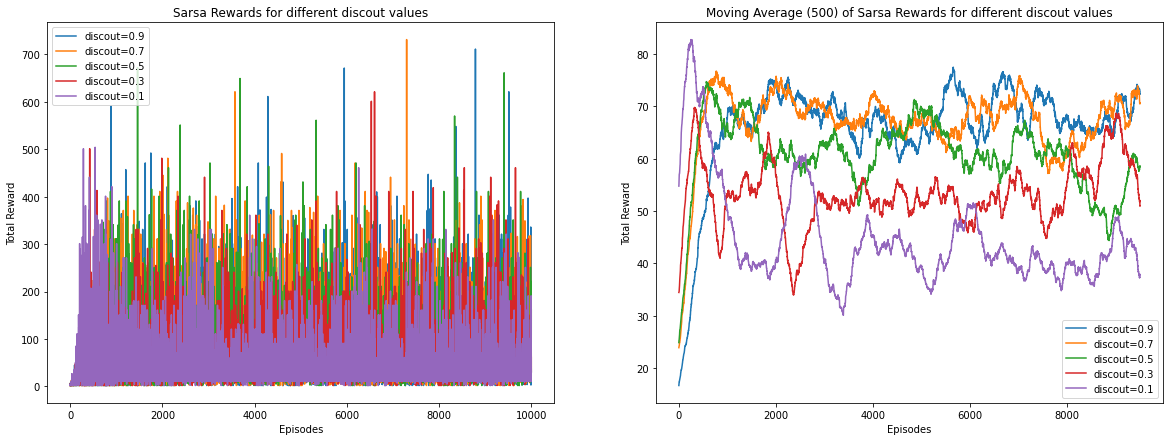

In [71]:
discout_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Dictionary to hold the rewards for each discout value
all_rewards = {}

# Loop over discout values, train the agent, and collect rewards
for disc in discout_values:
    print(f"training with discout={disc}")
    agent = SARSAgent(epsilon=0.1, learning_rate=0.5, discount=disc)
    all_rewards[disc] = agent.train(env, 10000)

def moving_average(rewards, window_size=500):
    """ Helper function to calculate the moving average of the rewards. """
    cumulative_sum = np.cumsum(np.insert(rewards, 0, 0)) 
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

plt.figure(figsize=(20,7))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
for disc, rewards in reversed(all_rewards.items()):
    plt.plot(rewards, label=f'discout={disc}')
plt.title('Sarsa Rewards for different discout values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 2, 2)
for disc, rewards in reversed(all_rewards.items()):
    plt.plot(moving_average(rewards), label=f'discout={disc}')
plt.title('Moving Average (500) of Sarsa Rewards for different discout values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

#### Learning Rate Finetuning for Sarsa Agent

training with learning rate=0.01


100%|██████████| 10000/10000 [00:02<00:00, 3845.41it/s]


training with learning rate=0.1


100%|██████████| 10000/10000 [00:13<00:00, 756.97it/s]


training with learning rate=0.5


100%|██████████| 10000/10000 [00:12<00:00, 802.20it/s]


training with learning rate=1


100%|██████████| 10000/10000 [00:05<00:00, 1971.57it/s]


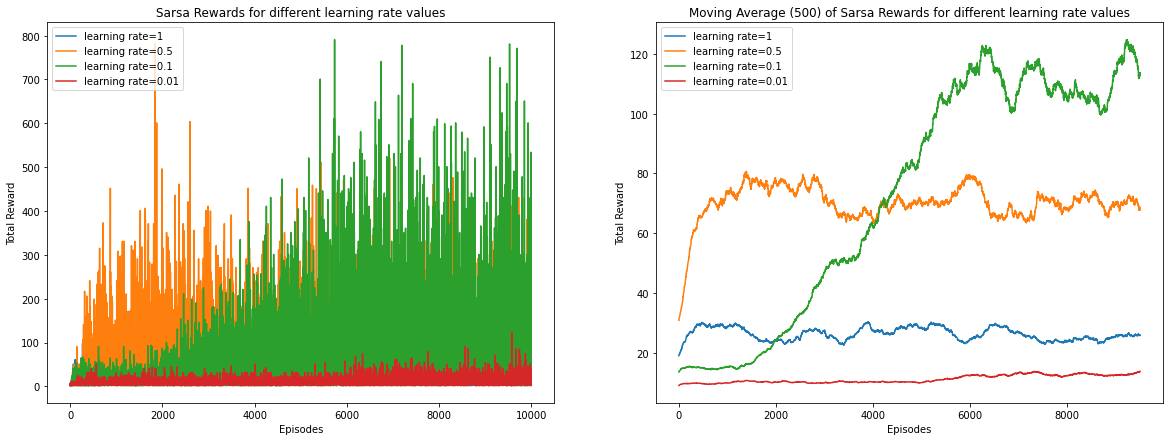

In [97]:
lr_values = [0.01, 0.1, 0.5, 1]

# Dictionary to hold the rewards for each learning rate value
all_rewards_lr = {}

# Loop over learning rate values, train the agent, and collect rewards
for lr in lr_values:
    print(f"training with learning rate={lr}")
    agent = SARSAgent(epsilon=0.1, learning_rate=lr, discount=0.9)
    all_rewards_lr[lr] = agent.train(env, 10000)

def moving_average(rewards, window_size=500):
    """ Helper function to calculate the moving average of the rewards. """
    cumulative_sum = np.cumsum(np.insert(rewards, 0, 0)) 
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

plt.figure(figsize=(20,7))

# Plot 1: Rewards
plt.subplot(1, 2, 1)
for lr, rewards in reversed(all_rewards_lr.items()):
    plt.plot(rewards, label=f'learning rate={lr}')
plt.title('Sarsa Rewards for different learning rate values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 2, 2)
for lr, rewards in reversed(all_rewards_lr.items()):
    plt.plot(moving_average(rewards), label=f'learning rate={lr}')
plt.title('Moving Average (500) of Sarsa Rewards for different learning rate values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

## Additional plots

In [82]:
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Dictionary to hold the rewards for each epsilon value
all_rewardsMC = {}
all_rewardsSarsa = {}

# Loop over epsilon values, train the agent, and collect rewards
for eps in epsilon_values:
    print(f"training with epsilon={eps}")
    agentMC = MonteCarloAgent(epsilon=eps, discount=0.9)
    all_rewardsMC[eps] = agentMC .train(env, 10000)
    agentSarsa = SARSAgent(epsilon=eps, learning_rate=0.5, discount=0.9)
    all_rewardsSarsa[eps] = agentSarsa.train(env, 10000)


training with epsilon=0.1


100%|██████████| 10000/10000 [00:12<00:00, 809.28it/s]


training with epsilon=0.2


100%|██████████| 10000/10000 [00:07<00:00, 1251.35it/s]


training with epsilon=0.3


100%|██████████| 10000/10000 [00:06<00:00, 1656.71it/s]


training with epsilon=0.4


100%|██████████| 10000/10000 [00:05<00:00, 1970.78it/s]


training with epsilon=0.5


100%|██████████| 10000/10000 [00:04<00:00, 2358.92it/s]


training with epsilon=0.6


100%|██████████| 10000/10000 [00:04<00:00, 2268.53it/s]


In [88]:
discout_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Dictionary to hold the rewards for each epsilon value
all_rewardsMC_disc = {}
all_rewardsSarsa_disc = {}

# Loop over epsilon values, train the agent, and collect rewards
for disc in discout_values:
    print(f"training with epsilon={disc}")
    agentMC = MonteCarloAgent(epsilon=0.1, discount=disc)
    all_rewardsMC_disc[disc] = agentMC.train(env, 10000)
    agentSarsa = SARSAgent(epsilon=0.1, learning_rate=0.5, discount=disc)
    all_rewardsSarsa_disc[disc] = agentSarsa.train(env, 10000)

training with epsilon=0.1


100%|██████████| 10000/10000 [00:09<00:00, 1036.60it/s]


training with epsilon=0.3


100%|██████████| 10000/10000 [00:10<00:00, 922.01it/s]


training with epsilon=0.5


100%|██████████| 10000/10000 [00:10<00:00, 912.13it/s]


training with epsilon=0.7


100%|██████████| 10000/10000 [00:12<00:00, 826.28it/s]


training with epsilon=0.9


100%|██████████| 10000/10000 [00:12<00:00, 827.17it/s]


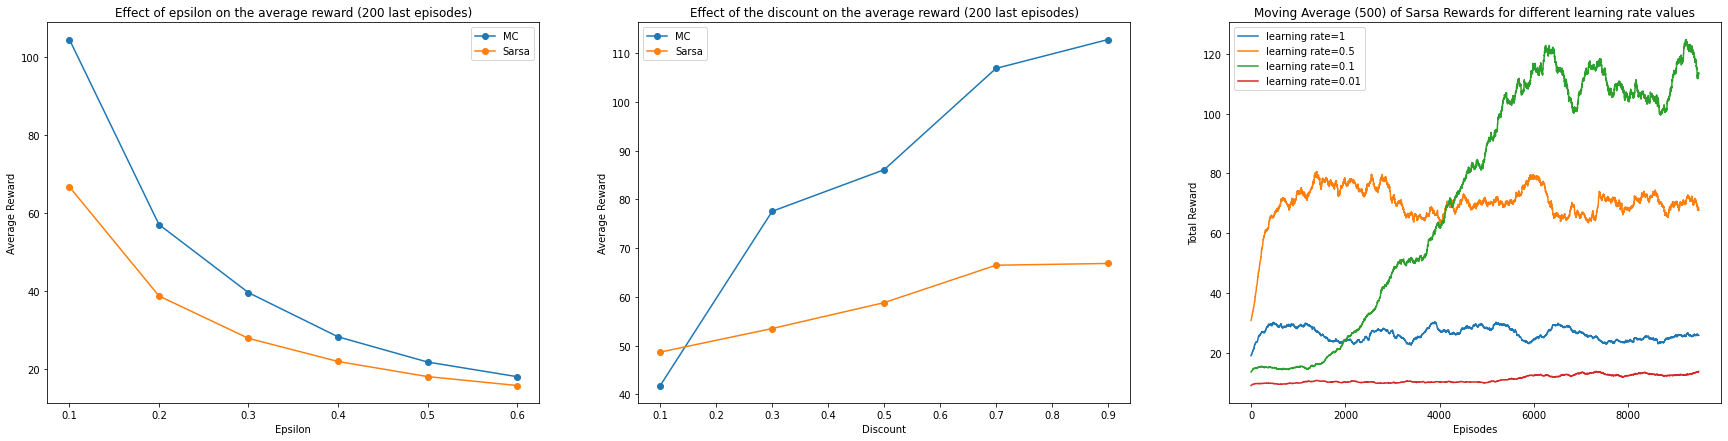

In [100]:
def average200(rewards):
    return [np.mean(rewards[key]) for key in rewards]

plt.figure(figsize=(30,7))

# Plot 1: Rewards
plt.subplot(1, 3, 1)
plt.plot(epsilon_values,average200(all_rewardsMC), label=f'MC', marker='o')
plt.plot(epsilon_values,average200(all_rewardsSarsa), label=f'Sarsa', marker='o')
plt.title('Effect of epsilon on the average reward (200 last episodes)')
plt.xlabel('Epsilon')
plt.ylabel('Average Reward')
plt.legend()

# Plot 2: Moving Average of Rewards
plt.subplot(1, 3, 2)
plt.plot(discout_values,average200(all_rewardsMC_disc), label=f'MC', marker='o')
plt.plot(discout_values,average200(all_rewardsSarsa_disc), label=f'Sarsa', marker='o')
plt.title('Effect of the discount on the average reward (200 last episodes)')
plt.xlabel('Discount')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(1, 3, 3)
for lr, rewards in reversed(all_rewards_lr.items()):
    plt.plot(moving_average(rewards), label=f'learning rate={lr}')
plt.title('Moving Average (500) of Sarsa Rewards for different learning rate values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()
plt.show()

# Summay

In our comparative study, we rigorously assessed the efficacy of two distinct reinforcement learning paradigms: a Monte Carlo Agent and a Sarsa Agent. Upon meticulous fine-tuning of various hyperparameters, the empirical evidence suggests a superior performance by the Monte Carlo Agent. The fine-tuning phase afforded us valuable insights into the balance between exploration and exploitation and showed the impact of hyperparameters on the agents' learning trajectories.